### Stock Market Prediction And Forecasting Using Stacked LSTM

In [ ]:
### Data Collection
!pip install yfinance

     |████████████████████████████████| 6.3 MB 8.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=d26d081685d10cd0d48141e686768cc4103b9123d192c67ab7dbdbe11921a923
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

In [ ]:
stock_name = 'TATASTEEL.NS'
stock = yf.Ticker(stock_name)
df = stock.history(period='5y')

In [ ]:
df 

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-11-11,369.559371,377.249638,362.296349,364.432526,9166446,0.0,0
2016-11-15,351.615435,357.169526,334.098751,335.850433,9712565,0.0,0
2016-11-16,339.225627,342.985312,325.425902,335.594116,8639027,0.0,0
2016-11-17,336.234958,340.592788,330.680894,335.594116,4578141,0.0,0
2016-11-18,333.286998,352.384464,325.767629,329.057343,4891327,0.0,0
...,...,...,...,...,...,...,...
2021-11-04,1331.000000,1335.000000,1324.099976,1325.900024,674434,0.0,0
2021-11-08,1340.900024,1347.650024,1306.099976,1343.250000,5493667,0.0,0
2021-11-09,1342.849976,1360.300049,1328.849976,1335.949951,4756516,0.0,0


In [ ]:
df1=df.reset_index()['Close']

In [ ]:
df['Close'].describe()

count    1234.000000
mean      562.073317
std       275.692500
min       241.925049
25%       400.064026
50%       481.765518
75%       601.450790
max      1519.400024
Name: Close, dtype: float64

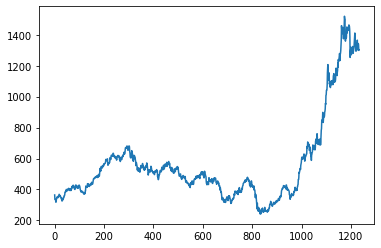

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.60)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(987, 247)

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# print(X_train.shape), print(y_train.shape)

In [ ]:
# print(X_test.shape), print(ytest.shape)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [ ]:
model.summary()

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=130,batch_size=64,verbose=1)

In [ ]:
# model.save('ts_7030.h5')

In [ ]:
# model = load_model('ts_7030.h5')

In [ ]:
 ### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
a = df[['Close']][time_step+1:training_size]
a['train_pred'] = train_predict
a

,Close,train_pred
Date,,
2017-04-10,423.262939,416.720764
2017-04-11,417.068085,418.769440
2017-04-12,407.925171,420.875427
2017-04-13,396.090759,422.043427
2017-04-17,395.108063,421.386566
...,...,...
2020-11-04,395.059204,405.737640
2020-11-05,416.186432,404.230011
2020-11-06,417.164520,402.472839


In [ ]:
mean_squared_error(a['Close'],a['train_pred'],squared=False)

18.1306241960634

In [ ]:
b = df[['Close']][training_size+time_step+1:]
b['test_pred'] = test_predict
b

,Close,test_pred
Date,,
2021-04-12,832.910767,865.806152
2021-04-13,859.759949,883.628967
2021-04-15,878.539734,889.107300
2021-04-16,870.763733,889.974976
2021-04-19,868.611877,889.919983
...,...,...
2021-11-04,1325.900024,1310.982300
2021-11-08,1343.250000,1313.840454
2021-11-09,1335.949951,1316.783447


In [ ]:
### Test Data RMSE
mean_squared_error(b['Close'],b['test_pred'],squared=False)

55.977472345130046

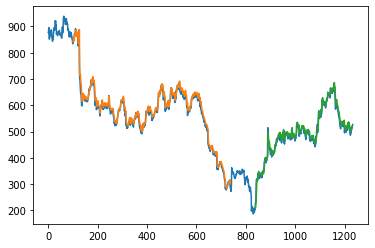

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
s1 = test_data.shape[0]-time_step

In [ ]:
x_input=test_data[s1:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.4556432]
101
1 day input [0.60235577 0.59812443 0.59931456 0.60030627 0.59918223 0.59739723
 0.58721557 0.60724822 0.63455343 0.61888437 0.61538031 0.61617367
 0.62880153 0.62800808 0.60989283 0.62853702 0.61095063 0.63223942
 0.62020667 0.62192558 0.63085103 0.61974382 0.66099919 0.65504886
 0.63528071 0.64149547 0.61187625 0.58080255 0.53101842 0.52956394
 0.53478691 0.55574518 0.55336509 0.55171219 0.54034047 0.54457181
 0.5412     0.53372903 0.52070457 0.51733277 0.50701885 0.49730003
 0.50536603 0.48506894 0.48454    0.46622633 0.45022667 0.44229293
 0.43971449 0.43065678 0.43561532 0.45102004 0.45373073 0.45604466
 0.46444126 0.45829259 0.46106937 0.45399516 0.44356609 0.44941165
 0.44163968 0.45871149 0.46449072 0.46382645 0.44183892 0.40962167
 0.42503284 0.43267199 0.4327384  0.42755707 0.4215786  0.41287659
 0.42888562 0.43067916 0.43426626 0.44310105 0.44310105 0.42310643
 0.43984609 0.45279944 0.46196645 0.45173661 0.45638653 0.44974379
 0.44203823 0.43758763 0.42463425 

In [ ]:
day_new=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+1+30)

In [ ]:
len(df1)

1234

In [ ]:
s2 = len(df1)-time_step
s2

1134

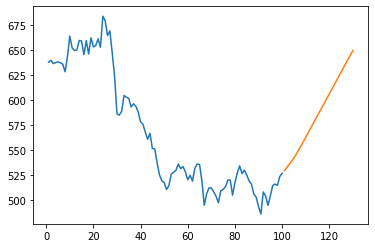

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[s2:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
# plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

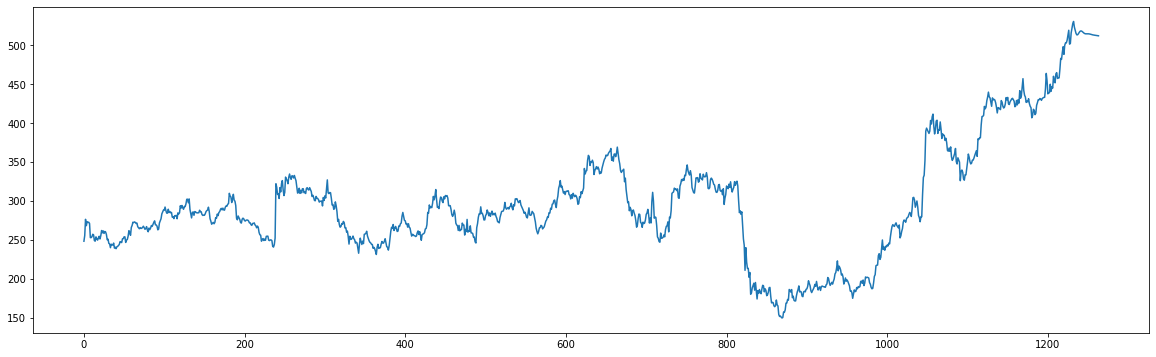

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(df3)
# plt.plot(day_pred,scaler.inverse_transform(lst_output))
# plt.plot(day_new,scaler.inverse_transform(df1[1135:]))

In [ ]:
# df_close = df[['Close']].reset_index(drop=True)

In [ ]:
# plt.figure(figsize=(20,6))
# plt.plot(df[['Close']])
# # plt.plot(tr['pred'], label='train')
# plt.plot(day_pred,scaler.inverse_transform(lst_output), label='test')
# plt.legend()

In [ ]:
scaler.inverse_transform(lst_output[:5])

array([[519.12496731],
       [515.24693291],
       [513.29225843],
       [513.30878998],
       [514.62786258]])